In [1]:
import sys
sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *

from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *
from mrl.reward import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)

In [3]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# vocab = FuncVocab(SELFIES_VOCAB, split_selfie,
#                   prefunc=smile_to_selfie, postfunc=selfie_to_smile)

ds = TextDataset(['CCC'], vocab)

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

# d_vocab = len(vocab.itos)
# d_embedding = 400
# d_hidden = 1552
# n_layers = 4
# lstm_drop = 0.
# lin_drop = 0.
# bos_idx = vocab.stoi['bos']
# bidir = False
# tie_weights = True

lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

# lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_large_lm_zinc.pt'))

# lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_chembl_selfies.pt'))
lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

loss = CrossEntropy()

In [4]:
# vh = ValueHead(400)
vh = ValueHead(256)
# vh = None

In [5]:
# latents = torch.randn((1024, lm_model.encoder.d_latent))
latents = None

In [6]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, value_head=vh, opt_kwargs={'lr':1e-4},
                       base_update=0.97, v_update=0.9, vopt_kwargs={'lr':1e-3},
                       latents=latents, lopt_kwargs={'lr':5e-2})

In [7]:
def scale_sa(sa):
    return (10-sa)/9

In [8]:
# template = Template([ValidityFilter(), SingleCompoundFilter()],
#                     [QEDFilter(None, None, score=PassThroughScore()),
#                      SAFilter(None, None, 
#                               score=PropertyFunctionScore(scale_sa))], fail_score=-1.)

# template = Template([ValidityFilter(), 
#                      SingleCompoundFilter(), 
#                      RotBondFilter(None, 8),
#                      ChargeFilter(None, 0)],
#                     [QEDFilter(0.5, None, score=1.),
#                      SAFilter(None, 6, score=1.)], 
#                     fail_score=-10., log=False)

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

In [9]:
update_cb = UpdateBaselineCB(agent, 5, 'base_update')
stat_cb = StatsCallback('live', 'stat_cb', 10)
# roll_cb = Rollback(agent.model, agent.base_model, 'live_valid', 5, 0.4, 0.5, 'rb')
roll_cb = RetrainRollback(agent, 98, 0.5, 5e-5, 64, 'live_valid', 20, 0.2, 'rb')
reward_cb = LogSampler('rewards', 10, 95, buffer_size=10)
enum_cb = LogEnumerator('rewards', 10, buffer_size=5, percentile=98)
train_cb = SupevisedCB(agent, 200, 0.5, 98, 5e-5, 64)
novel_cb = NoveltyBonus(0.1, 'novel')

In [10]:
# cbs = [update_cb, stat_cb, roll_cb, reward_cb, enum_cb, train_cb]
cbs = [update_cb, stat_cb, roll_cb, reward_cb, enum_cb, novel_cb, train_cb]
# cbs = [update_cb, reward_cb, enum_cb, novel_cb, train_cb]

In [11]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')

r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/aff_pred.pt')

r_model.eval();

freeze(r_model)

# class RF():
#     def __init__(self, agent):
#         self.agent = agent
        
#     def __call__(self, inputs):
#         with torch.no_grad():
#             return self.agent.predict_data(inputs)

# aff_reward = SampleReward(RF(r_agent), True, 'aff', weight=-10.)
aff_reward = SampleReward(r_agent.predict_data, True, 'aff', weight=-10.)

In [12]:
gen_bs = 1400
bs = 200

In [13]:
agent_cb = GenAgentCallback(agent, 'generative')

In [15]:
sampler1 = ModelSampler(agent, agent.model, 'live', 2000, 0.4, gen_bs, latent=False)
sampler2 = ModelSampler(agent, agent.base_model, 'base', 2000, 0., gen_bs)

samplers = [sampler1, sampler2]

# zinc_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
#                 lstm_drop, lin_drop, bos_idx, bidir, tie_weights)
# to_device(zinc_model)
# zinc_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

# sampler2 = ModelSampler(agent, zinc_model, 'base', 0.25, 0., gen_bs)

# chembl_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
#                 lstm_drop, lin_drop, bos_idx, bidir, tie_weights)
# to_device(chembl_model)
# chembl_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_chembl.pt'))

# sampler3 = ModelSampler(agent, chembl_model, 'base', 0.25, 0., gen_bs)

# samplers = [sampler1, sampler2, sampler3]

In [16]:
# pg = PolicyGradient(ratio=True)
# pg = TRPO(0.97, 4.)
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss1 = LossCallback(pg, 'pg')

In [17]:
template_cb = TemplateCallback(template, prefilter=True)

In [18]:
env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss1],
                 cbs=cbs)

# env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[loss1],
#                  cbs=cbs)

In [18]:
%%time
env.fit(bs, 90, 6, 2)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
0,-6.509,1.922,1.000,0.830,166,0.582,1.000,0.717,-6.458,1.000,-8.530,-4.432,-2.072,0.100
2,-6.492,1.948,1.000,0.765,153,0.545,1.000,0.608,-6.473,1.000,-8.539,-4.137,-2.032,0.100
4,-6.625,1.951,1.000,0.815,163,0.661,1.000,0.692,-6.713,1.000,-8.676,-5.064,-1.826,0.100


CPU times: user 1min 50s, sys: 1.93 s, total: 1min 52s
Wall time: 12.9 s


In [19]:
%%time
env.fit(bs, 100, 1500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
0,-8.781,0.000,1.000,0.780,156,0.718,1.000,0.450,-8.940,1.000,-8.881,-7.158,-5.142,0.100
10,-8.690,0.000,1.000,0.750,150,0.513,1.000,0.375,-8.556,1.000,-8.790,-6.296,-5.366,0.100
20,-8.224,0.000,1.000,0.790,158,0.763,1.000,0.475,-8.124,1.000,-8.323,-5.951,-4.521,0.099
30,-8.028,0.000,1.000,0.775,155,0.711,1.000,0.438,-8.427,1.000,-8.128,-6.396,-5.368,0.100
40,-7.992,0.000,1.000,0.775,155,0.750,1.000,0.438,-8.145,1.000,-8.091,-5.950,-3.218,0.099
50,-8.017,0.000,1.000,0.780,156,0.636,1.000,0.450,-8.339,1.000,-8.117,-6.086,-5.072,0.100
60,-8.158,0.000,1.000,0.735,147,0.656,1.000,0.338,-7.778,1.000,-8.257,-6.313,-4.653,0.099
70,-8.081,0.000,1.000,0.730,146,0.715,1.000,0.325,-7.730,1.000,-8.180,-5.815,-4.748,0.099
80,-7.903,0.000,1.000,0.835,167,0.625,1.000,0.588,-7.904,1.000,-8.002,-5.961,-1.124,0.099
90,-7.982,0.000,1.000,0.760,152,0.727,1.000,0.400,-7.960,1.000,-8.081,-5.371,-4.775,0.099


Epoch,Train Loss,Valid Loss,Time
0,0.64645,0.57359,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.45341,0.66657,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.61489,0.58845,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46236,0.55672,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.41329,0.45822,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.42551,0.41212,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.38504,0.42367,00:01


CPU times: user 7h 9min 35s, sys: 6min 10s, total: 7h 15min 45s
Wall time: 1h 25min 23s


In [21]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])

In [22]:
log_df.drop_duplicates(subset='samples', inplace=True)

In [23]:
log_df[(log_df.rewards>env.log.metrics['rewards'][-50]) & (log_df.template>-5)].shape

(20699, 7)

In [24]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

<All keys matched successfully>

In [25]:
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>env.log.metrics['rewards'][-50])  & (log_df.template>-5)].samples.values)

In [26]:
agent.train_supervised(128, 2, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.53688,0.59820,00:07
1,0.38552,0.41341,00:07


In [27]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [29]:
env.buffer.buffer = []

In [30]:
%%time
env.fit(bs, 100, 1500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
1500,-6.931,0.000,1.000,0.780,156,2.083,1.000,0.450,-6.818,0.917,-7.023,-3.674,-2.890,0.092
1510,-6.933,0.000,1.000,0.745,149,1.302,1.000,0.362,-7.000,0.931,-7.027,-3.654,-2.382,0.095
1520,-6.966,0.000,1.000,0.800,160,1.416,1.000,0.500,-7.237,0.950,-7.061,-3.972,-3.278,0.095
1530,-7.134,0.000,1.000,0.760,152,1.212,1.000,0.400,-7.117,0.938,-7.230,-3.757,-3.350,0.095
1540,-7.064,0.000,1.000,0.810,162,1.061,1.000,0.525,-7.171,0.881,-7.154,-4.076,-3.203,0.090
1550,-7.174,0.000,1.000,0.750,150,1.076,1.000,0.375,-6.663,0.900,-7.268,-3.605,-3.141,0.095
1560,-6.956,0.000,1.000,0.770,154,0.929,1.000,0.425,-7.020,0.941,-7.052,-4.233,-3.716,0.095
1570,-6.865,0.000,1.000,0.720,144,1.060,1.000,0.300,-7.497,1.000,-6.960,-5.293,-4.314,0.095
1580,-6.806,0.000,1.000,0.710,142,0.946,1.000,0.275,-7.299,1.000,-6.899,-4.259,-2.715,0.093
1590,-7.183,0.000,1.000,0.755,151,0.811,1.000,0.388,-6.781,0.935,-7.280,-4.086,-2.508,0.097


Epoch,Train Loss,Valid Loss,Time
0,0.41620,0.41658,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.38850,0.35390,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.41854,0.35459,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.32896,0.36491,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.30684,0.24409,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.31866,0.27110,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.32382,0.26538,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.25736,0.25336,00:02


CPU times: user 7h 25min 1s, sys: 6min 20s, total: 7h 31min 21s
Wall time: 1h 34min 20s


In [31]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])
log_df.drop_duplicates(subset='samples', inplace=True)
log_df[(log_df.rewards>env.log.metrics['rewards'][-50]) & (log_df.template>-5)].shape

(17232, 7)

In [32]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>env.log.metrics['rewards'][-50]) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 2, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.44577,0.44883,00:08
1,0.28669,0.28927,00:08


<All keys matched successfully>

In [34]:
%%time
env.fit(bs, 100, 1500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
3000,-2.504,0.000,0.994,0.785,157,1.487,0.973,0.463,-3.481,0.595,-2.558,-1.285,-0.616,0.054
3010,-4.741,0.000,1.000,0.735,147,1.512,1.000,0.338,-5.054,0.704,-4.819,-1.965,-1.639,0.078
3020,-4.880,0.000,1.000,0.775,155,1.328,1.000,0.438,-5.269,0.743,-4.953,-2.641,-2.113,0.074
3030,-5.119,0.000,0.994,0.775,155,1.233,0.971,0.438,-5.032,0.771,-5.201,-2.120,-1.847,0.082
3040,-5.214,0.000,1.000,0.750,150,1.215,1.000,0.375,-5.880,0.800,-5.293,-2.327,-1.561,0.079
3050,-4.101,0.000,1.000,0.765,153,0.866,1.000,0.412,-4.016,0.758,-4.179,-1.641,-0.895,0.077
3060,-4.487,0.000,1.000,0.790,158,0.837,1.000,0.475,-4.486,0.632,-4.557,-1.808,-1.053,0.070
3070,-4.577,0.000,0.994,0.800,160,0.702,0.975,0.500,-4.428,0.575,-4.654,-1.532,-0.349,0.078
3080,-4.482,0.000,1.000,0.760,152,0.794,1.000,0.400,-4.738,0.438,-4.551,-1.603,-1.089,0.069
3090,-4.085,0.000,1.000,0.755,151,0.668,1.000,0.388,-3.714,0.677,-4.156,-1.575,-1.089,0.072


Epoch,Train Loss,Valid Loss,Time
0,0.30134,0.26450,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.27755,0.29212,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.16813,0.24413,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22481,0.24107,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.20590,0.22622,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.18249,0.26232,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24790,0.24517,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.27154,0.18369,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.25197,0.21827,00:03


CPU times: user 7h 11min 42s, sys: 6min 19s, total: 7h 18min 2s
Wall time: 1h 22min 11s


In [43]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])
log_df.drop_duplicates(subset='samples', inplace=True)
log_df[(log_df.rewards>-1.5) & (log_df.template>-5)].shape

(29239, 7)

In [44]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>-1.5) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 2, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.31386,0.33374,00:14
1,0.27144,0.22574,00:14
2,0.29122,0.20482,00:14


<All keys matched successfully>

In [45]:
%%time
env.fit(bs, 100, 1500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
4730,-6.037,0.000,1.000,0.775,155,3.047,1.000,0.438,-2.840,0.743,-6.125,-0.400,1.107,0.088
4740,-5.698,0.000,1.000,0.810,162,3.588,1.000,0.525,-1.748,0.357,-5.775,0.062,0.318,0.077
4750,-1.770,0.000,1.000,0.740,148,5.284,1.000,0.350,-1.463,0.536,-1.819,0.117,0.368,0.049
4760,-2.212,0.000,1.000,0.655,131,4.030,1.000,0.138,-2.761,0.727,-2.267,-1.564,-0.315,0.055
4770,-1.427,0.000,1.000,0.860,172,4.050,1.000,0.650,-0.880,0.250,-1.468,0.393,1.047,0.041
4780,-1.446,0.000,1.000,0.800,160,3.069,1.000,0.500,-1.410,0.200,-1.484,0.229,0.428,0.038
4790,-1.694,0.000,1.000,0.835,167,2.155,1.000,0.588,-1.546,0.298,-1.736,0.383,0.718,0.042
4800,-1.419,0.000,1.000,0.865,173,1.791,1.000,0.662,-1.436,0.094,-1.452,0.211,0.751,0.032
4810,-1.139,0.000,1.000,0.830,166,1.707,1.000,0.575,-0.804,0.109,-1.177,0.605,0.814,0.038
4820,-1.313,0.000,1.000,0.845,169,1.176,1.000,0.613,-1.315,0.184,-1.344,0.115,1.126,0.031


Epoch,Train Loss,Valid Loss,Time
0,0.21082,0.23528,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.17576,0.20673,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.22167,0.19561,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24525,0.25840,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24071,0.24429,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.28089,0.21174,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24504,0.20759,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.23309,0.23044,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.24358,0.24066,00:03


KeyboardInterrupt: 

In [47]:
torch.cuda.empty_cache()

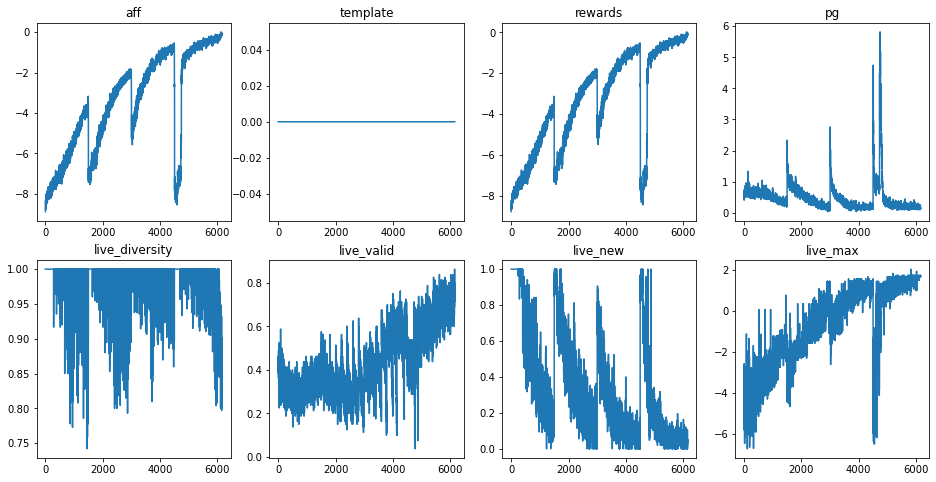

In [48]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['aff', 'template', 'rewards', 'pg',
             'live_diversity', 'live_valid', 'live_new', 'live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

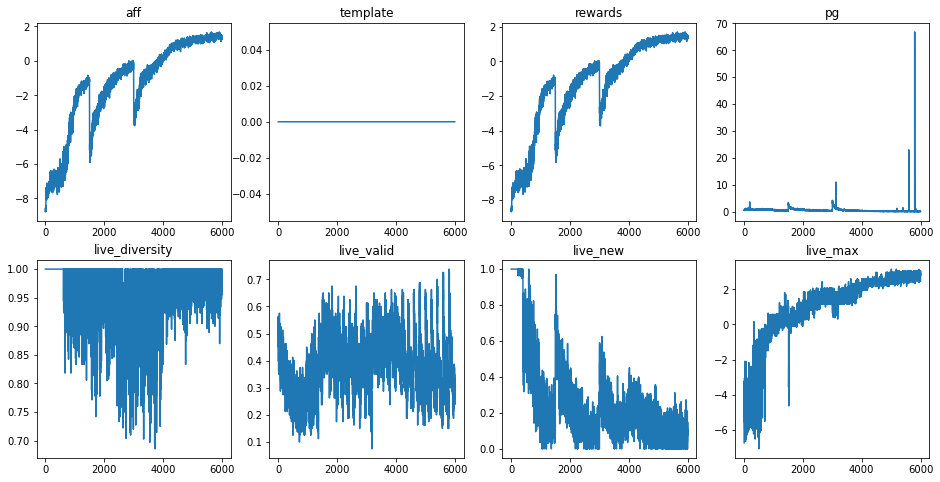

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['aff', 'template', 'rewards', 'pg',
             'live_diversity', 'live_valid', 'live_new', 'live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

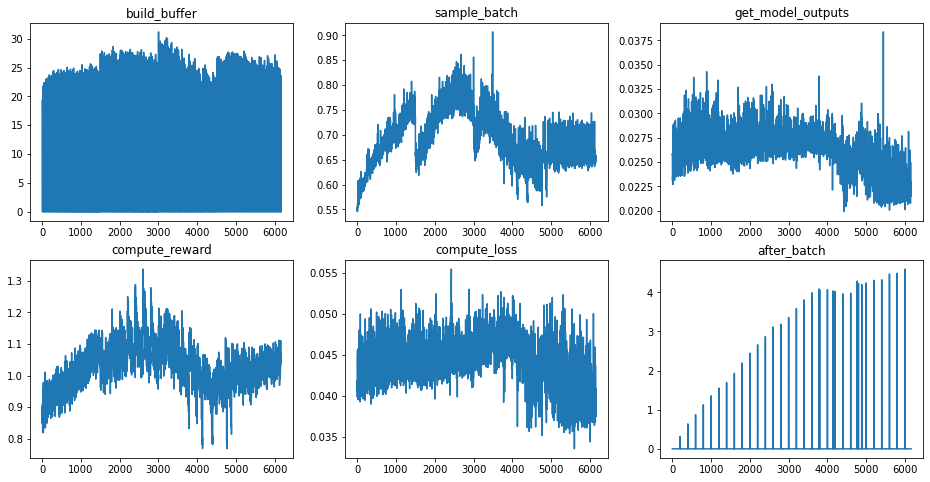

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

In [49]:
len(vocab.unks) # see if predicting unk or something weird is happening

1

In [50]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])

In [51]:
log_df = log_df.drop_duplicates(subset='samples')

In [57]:
log_df[(log_df.aff>1.7) & (log_df.template>-1)]

,batch,samples,sources,rewards,template,aff,novel
768314,5097,CNc1cc(N(C)c2cc(O)c(C)cc2OCc2cc(CO)cc(C=S)c2C)...,buffer,1.811989,0,1.711989,0.1
779798,5166,CNc1cc(Nc2cc(F)c(C)cc2OC(C)c2cccc(O)c2O)ncn1,buffer,1.894483,0,1.794483,0.1
783856,5190,CNc1cc(Nc2cc(C)c(O)cc2OC(C)c2cccc(OF)c2)ncn1,live,1.830725,0,1.730725,0.1
786460,5206,CNOc1cccc(C(C)Oc2cc(O)c(C)cc2Nc2cc(NC)ncn2)c1,buffer,1.812840,0,1.712840,0.1
862049,5647,CNc1cc(Nc2cc(C)c(O)cc2OC(C)c2c(C)cc(C#CN)cc2F)...,buffer,1.826017,0,1.726017,0.1
891531,5816,CNc1cc(N(C)c2cc(CN)ccc2OC(C)c2cc(C)c(O)cc2F)ncn1,live,2.032896,0,1.932896,0.1
907544,5907,CNc1cc(N(C)c2cc(OC)c(C)cc2O[C@H](C)c2cc(O)c(C)...,buffer,1.960745,0,1.860745,0.1
922201,5991,CNc1cc(Nc2cc(C)c(O)cc2OC(C)c2cccc(SCO)c2)ncn1,buffer,1.954731,0,1.854731,0.1
933267,6054,CNc1cc(N(C)c2cc(OC)c(C)cc2OC(C)c2cc(O)c(C)cc2F...,buffer,1.960745,0,1.860745,0.1
934653,6062,CNc1cc(Nc2cc(ON)c(O)cc2OC(C)c2cccc(C)c2)ncn1,buffer,1.901555,0,1.801555,0.1


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

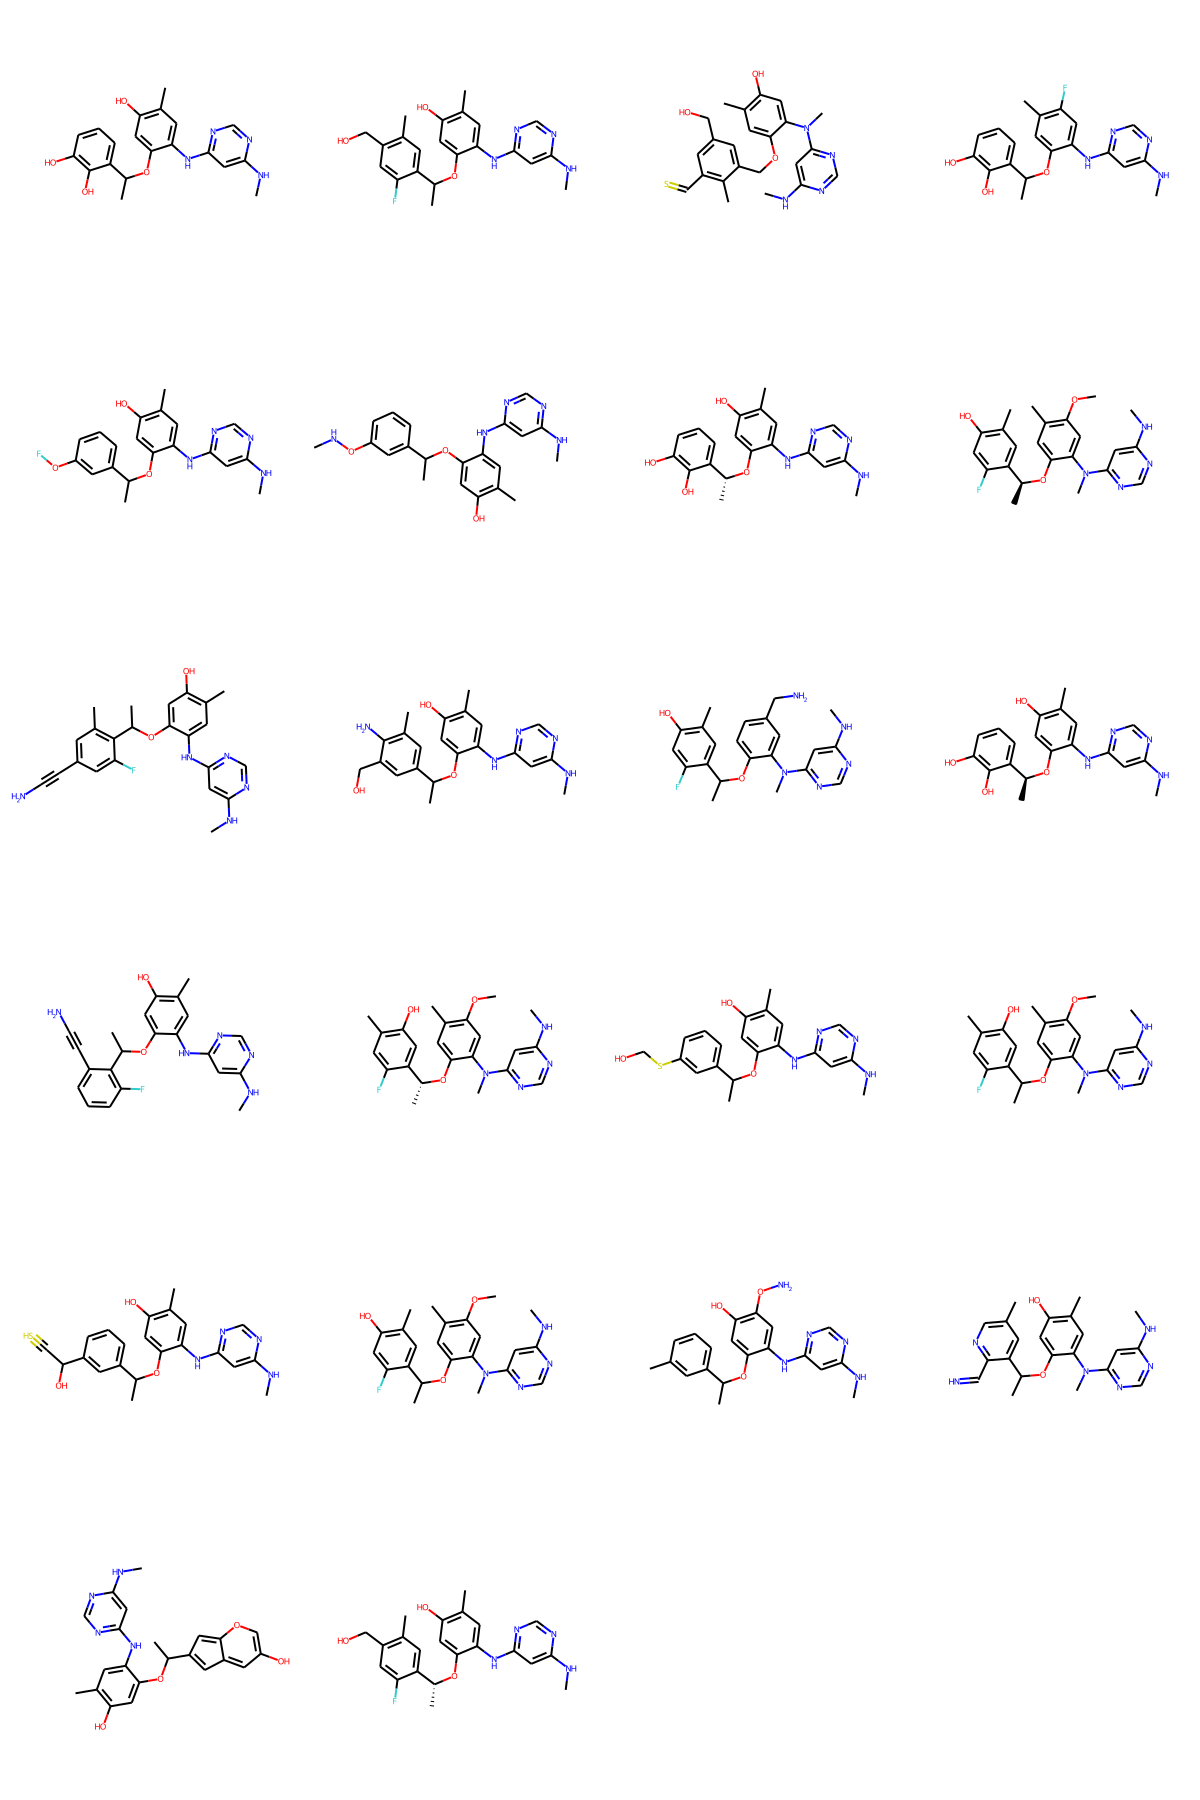

In [58]:
draw_mols(to_mols(log_df[(log_df.rewards>1.7)].samples.values), mols_per_row=4)

In [59]:
from rdkit import Chem

In [80]:
smarts = ['[#16]#[*]',
          '[#16]=[*]'
          '[#7]-[#8]',
          '[#8][F,Cl,Br,I]',
          '[!#6][F,Cl,Br,I]'
    
    
    
    '[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

In [81]:
cat = SmartsCatalog(smarts)

In [69]:
mols = to_mols(log_df[(log_df.rewards>2.2)].samples.values)

In [82]:
cat(mols)

[[False, True, False, False, True],
 [False, True, False, True, False],
 [False, True, False, False, False],
 [True, True, False, False, False],
 [False, True, True, True, False],
 [True, True, False, False, False],
 [True, True, False, False, False],
 [False, True, False, False, True],
 [False, True, False, True, False],
 [False, True, True, False, True],
 [True, True, False, False, False],
 [True, True, False, False, False],
 [False, True, False, False, True]]

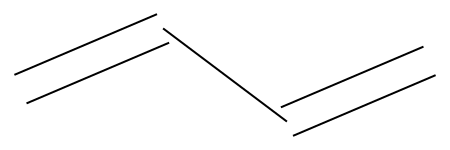

In [75]:
Chem.MolFromSmiles('C-C=C-C=C-C')

In [77]:
cat(Chem.MolFromSmiles('C-C=C-C=C-C'))

[False, False, False, False]

In [ ]:
'[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]'

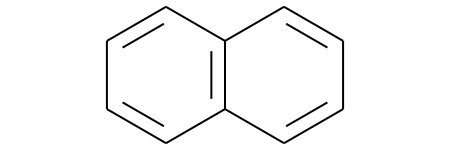

In [79]:
to_mol('C1=CC=CC2=C1C=CC=C2')

In [ ]:
class DuplicatePenalty(Callback):
    def __init__(self):
        super().__init__(name='dup_penalty', order=100)
        
    def after_compute_reward